In [171]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
import sympy as sym

In [172]:
def ecuacion_plano(puntos):
    p0, p1, p2 = puntos
    x0, y0, z0 = p0
    x1, y1, z1 = p1
    x2, y2, z2 = p2

    ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
    vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

    u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

    point  = np.array(p0)
    normal = np.array(u_cross_v)

    d = -point.dot(normal)

    Presupuesto = (-normal[0] * A - normal[1] * B - d) * 1. / normal[2]

    return Presupuesto

In [173]:
def ecuacion(A, B, C):
    return -787.09 + 34.22*A + 707.37*B + 5659.41*C - 0.64*A**2 - 176.08*B**2 - 16520.51*C**2 - 1481.21*B*C

A,B = np.mgrid[20:40:20j, 1:2:20j]
C=np.mgrid[0.05:0.15:20j]

## Sin Presupuesto

### Gráfica A-B-Y

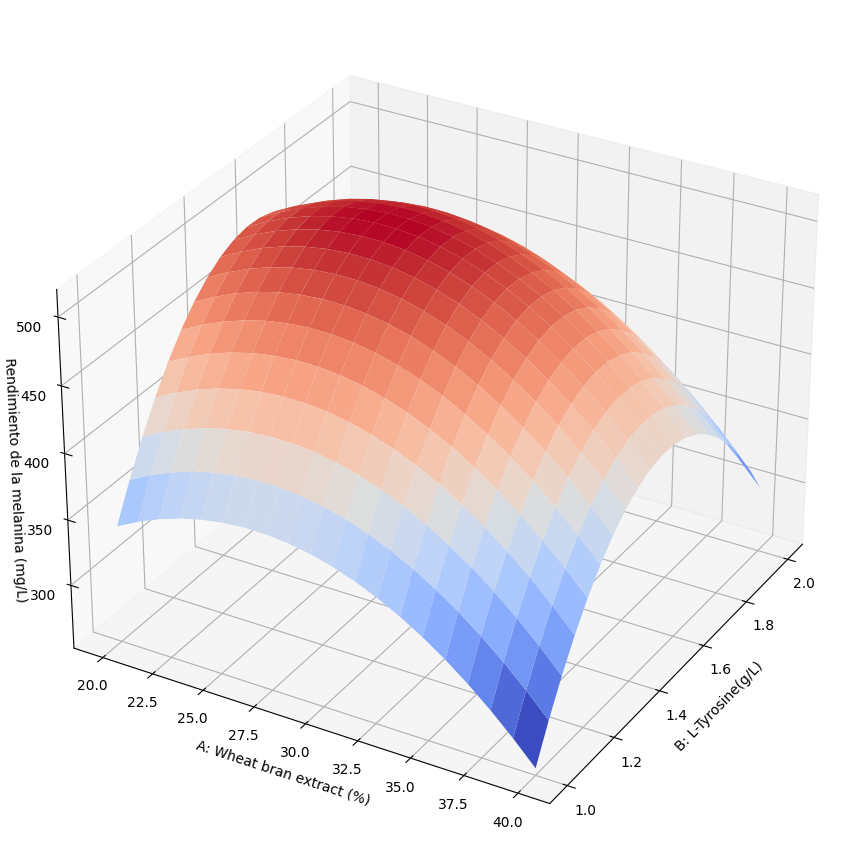

In [4]:
fig = plt.figure(figsize=(11, 11))

ax = fig.add_subplot(projection='3d')
ax.plot_surface(A, B, ecuacion(A, B, C), cmap='coolwarm')


# Etiquetar los ejes
ax.set_xlabel('A: Wheat bran extract (%)')
ax.set_ylabel('B: L-Tyrosine(g/L)')
ax.set_zlabel('Rendimiento de la melanina (mg/L)', labelpad=-0.3)

ax.zaxis._axinfo['juggled'] = (1,2,1)

# Mostrar la gráfica
plt.show()

### Gráfica A-C-Y

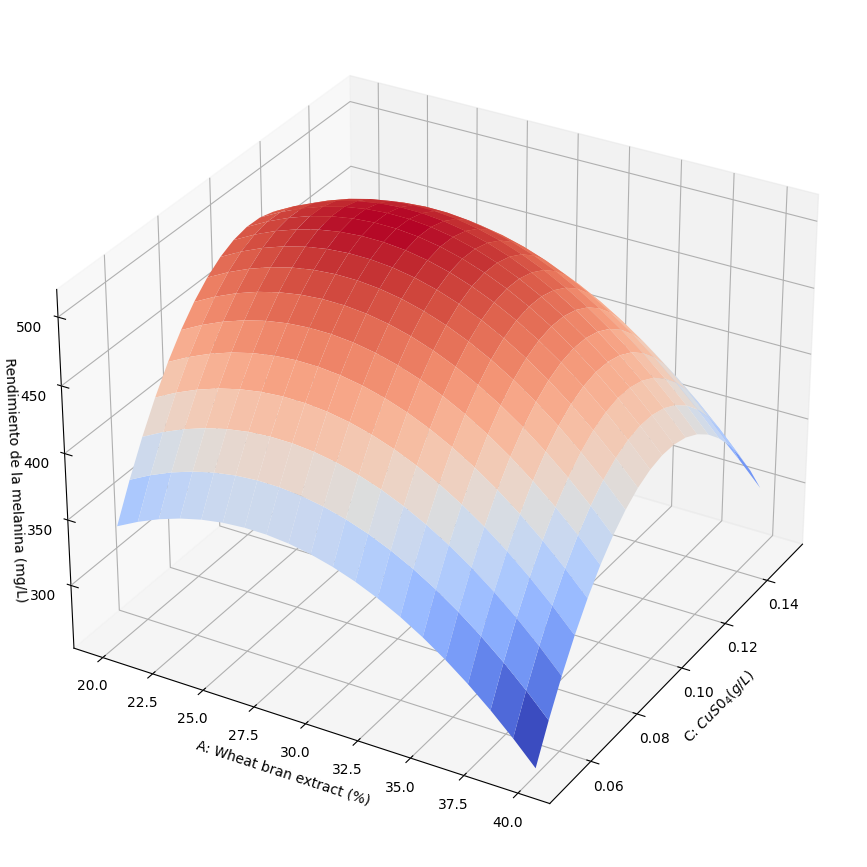

In [5]:
fig = plt.figure(figsize=(11, 11))

ax = fig.add_subplot(projection='3d')
ax.plot_surface(A, C, ecuacion(A, B, C), cmap='coolwarm')


# Etiquetar los ejes
ax.set_xlabel('A: Wheat bran extract (%)')
ax.set_ylabel('C: $CuS0_4(g/L)$')
ax.set_zlabel('Rendimiento de la melanina (mg/L)', labelpad=-0.3)

ax.zaxis._axinfo['juggled'] = (1,2,1)

# Mostrar la gráfica
plt.show()

### Gráfica B-C-Y

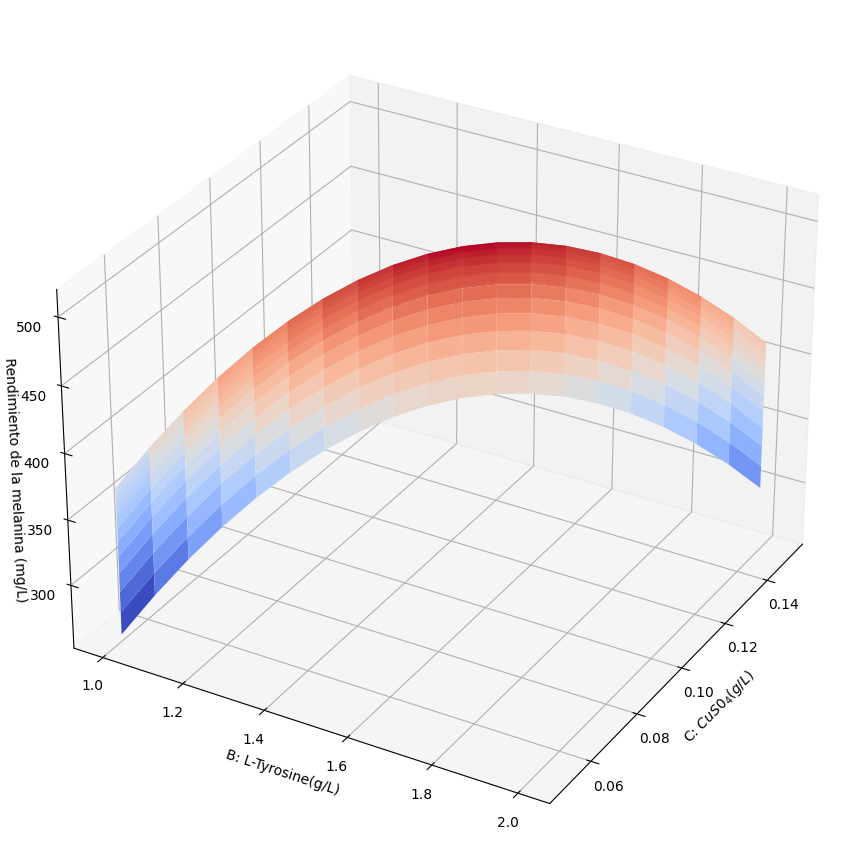

In [6]:
fig = plt.figure(figsize=(11, 11))

ax = fig.add_subplot(projection='3d')
ax.plot_surface(B, C, ecuacion(A, B, C), cmap='coolwarm')


# Etiquetar los ejes
ax.set_xlabel('B: L-Tyrosine(g/L)')
ax.set_ylabel('C: $CuS0_4(g/L)$')
ax.set_zlabel('Rendimiento de la melanina (mg/L)', labelpad=-0.3)

ax.zaxis._axinfo['juggled'] = (1,2,1)

# Mostrar la gráfica
plt.show()

## Con Presupuesto

La función objetivo es

$$
max Y = -787.09 + 34.22\cdot A + 707.37\cdot B + 5659.41\cdot C - 0.64*A^{2} - 176.08\cdot B^{2} - 16520.51\cdot C^{2} - 1481.21\cdot B\cdot C
$$
sujeto A

$$
A\cdot Precio\_A < Presupuesto\_A
$$

$$
B\cdot Precio\_B < Presupuesto\_B
$$

$$
C\cdot Precio\_C < Presupuesto\_C
$$

$$
A\geq 0
\\ 
B\geq 0 
\\ 
C\geq 0 
$$

### Optimización Pyomo

1. Definir constantes

l-tyrosine de 1 a 99 kilogramos cuesta 19 usd entonces

1kg de l-tyrosine = 19 usd
1kg = 1000 gramos

entonces el costo de 0.12 gramos = (19*0.12)/1000

In [146]:
kg_A=0.025
gm_A=1000*kg_A
precio_dolares_kg_A=14

kg_B=0.0015
gm_B=1000*kg_B
precio_dolares_kg_B=19

kg_C=0.00012
gm_C=1000*kg_C
precio_dolares_kg_C=2.50

Precio_dolares_A= (precio_dolares_kg_A*gm_A)/1000

Precio_dolares_B= (precio_dolares_kg_B*gm_B)/1000

Precio_dolares_C= (precio_dolares_kg_C*gm_C)/1000

print('El precio de A  es de %s' % Precio_dolares_A)
print('El precio de B  es de %s' % Precio_dolares_B)
print('El precio de C  es de %s' % Precio_dolares_C)

El precio de A  es de 0.35
El precio de B  es de 0.0285
El precio de C  es de 0.00030000000000000003


In [174]:
Presupuesto_A=Precio_dolares_A*20 # por que hay 20 valores en A, B y C
Presupuesto_B=Precio_dolares_B*20
Presupuesto_C=Precio_dolares_C*20

print('El presupuesto total de A %s' % Presupuesto_A)
print('El presupuesto total de B %s' % Presupuesto_B)
print('El presupuesto total de C %s' % Presupuesto_C)

El presupuesto total de A 7.0
El presupuesto total de B 0.5700000000000001
El presupuesto total de C 0.006


2. Crear modelo

In [175]:
model=ConcreteModel()

3. Declaración de variables de decisión

In [176]:
model.A=Var(within=NonNegativeReals)
model.B=Var(within=NonNegativeReals)
model.C=Var(within=NonNegativeReals)

4. Función objetivo

In [150]:
model.maximizeZ = Objective(expr=-787.09 + 34.22*model.A + 707.37*model.B + 5659.41*model.C - 0.64*(model.A**2) - 176.08*(model.B**2)  - 16520.51*(model.C**2)  - 1481.21*model.B*model.C, sense=maximize)

5. Restricción

In [151]:
model.Presupuesto_A = Constraint(expr = model.A*Precio_dolares_A <= Presupuesto_A)
model.Presupuesto_B = Constraint(expr = model.B*Precio_dolares_B <= Presupuesto_B)
model.Presupuesto_C = Constraint(expr = model.C*Precio_dolares_C <= Presupuesto_C)

#model.pprint()

6. Método de solución 

In [152]:
SolverFactory('ipopt',executable='C://ipopt//bin//ipopt').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 3
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.3303556442260742
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


7. Imprimir Solución

In [158]:
print('\nDecision Variables')
print('A = ', round(model.A(),3))
print('B = ', round(model.B(),3))
print('C = ', round(model.C(),3))
print('Y = ', round(model.maximizeZ(),3))
print('Presupuesto_A = ', round(model.Presupuesto_A(),3))
print('Presupuesto_B = ', round(model.Presupuesto_B(),3))
print('Presupuesto_C = ', round(model.Presupuesto_C(),3))


Decision Variables
A =  20.0
B =  1.588
C =  0.1
Y =  486.105
Presupuesto_A =  7.0
Presupuesto_B =  0.045
Presupuesto_C =  0.0


8. Puntos de intercepción

In [159]:
a = sym.Symbol('a')
b = sym.Symbol('b')
c = sym.Symbol('c')
y = sym.Symbol('y')

eq1 = -787.09 + 34.22*a + 707.37*b + 5659.41*c - 0.64*(a**2) - 176.08*(b**2) - 16520.51*(c**2) - 1481.21*b*c
eq2 = a*Precio_dolares_A
eq3 = b*Precio_dolares_B
eq4 = c*Precio_dolares_C

resp1 = sym.lambdify([a,b,c],eq1)
resp2 = sym.lambdify([a],eq2)
resp3 = sym.lambdify([b],eq3)
resp4 = sym.lambdify([c],eq4)

N_punto_1='['+str(round(model.A(),3))+','+str(round(model.B(),3))+','+str(round(model.C(),3))+','+str(round(resp1(model.A(),model.B(),model.C()),3))+']'
N_punto_2='['+str(round(A[0][0],3))+','+str(round(B[0][0],3))+','+str(round(C[0],3))+','+str(round(resp1(A[0][0],B[0][0],C[0]),3))+']'
N_punto_3='['+str(round(A[1][0],3))+','+str(round(B[0][1],3))+','+str(round(C[1],3))+','+str(round(resp1(A[1][0],B[0][1],C[1]),3))+']'


print(N_punto_1)
print(N_punto_2)
print(N_punto_3)

[20.0,1.588,0.1,486.105]
[20.0,1.0,0.05,340.209]
[21.053,1.053,0.055,375.31]


In [167]:
puntos = [[20.0,1.588,486.105],
           [20.0,1.0,340.209],
           [21.053,1.053,375.31]]

#### Gráfica A-B-Y

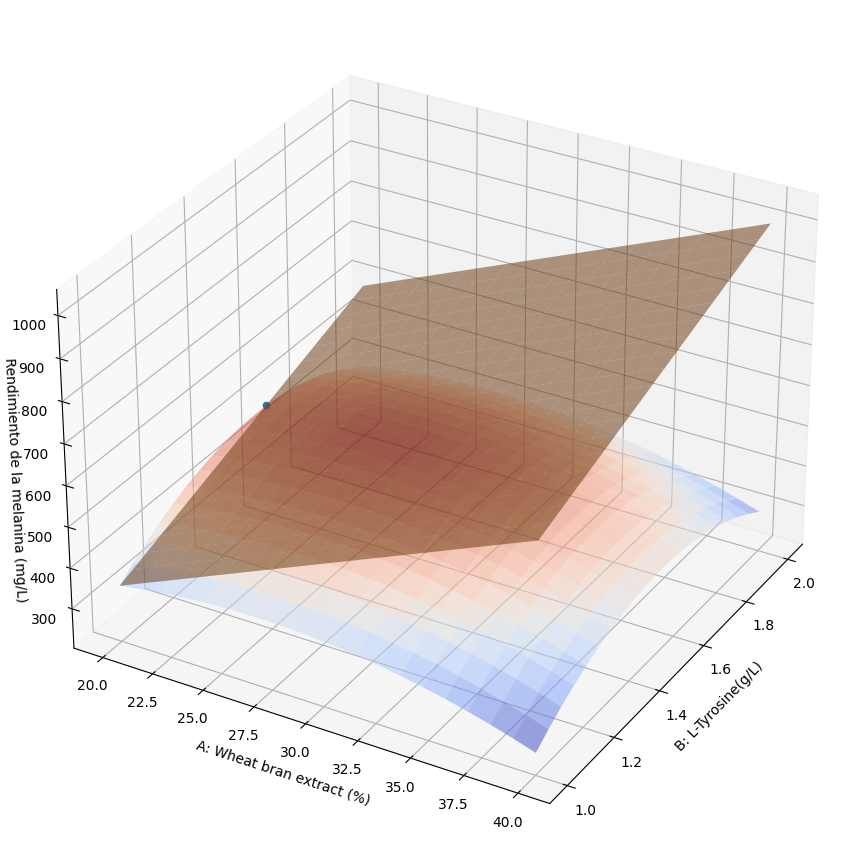

In [168]:
fig = plt.figure(figsize=(11, 11))

ax = fig.add_subplot(projection='3d')
ax.plot_surface(A, B , ecuacion(A, B, C), cmap='coolwarm',linewidth=0.5, antialiased=True, alpha=0.5)
ax.scatter(model.A(),model.B(),resp1(model.A(),model.B(),model.C()), alpha = 1) #Presupuesto adecuado evaluado en la función
ax.plot_surface(A, B , ecuacion_plano(puntos), linewidth=0.5, antialiased=True, alpha = 0.5) # Plano del presupuesto

# Etiquetar los ejes
ax.set_xlabel('A: Wheat bran extract (%)')
ax.set_ylabel('B: L-Tyrosine(g/L)')
ax.set_zlabel('Rendimiento de la melanina (mg/L)', labelpad=-0.3)

ax.zaxis._axinfo['juggled'] = (1,2,1)

# Mostrar la gráfica
plt.show()

#### Gráfica A-C-Y

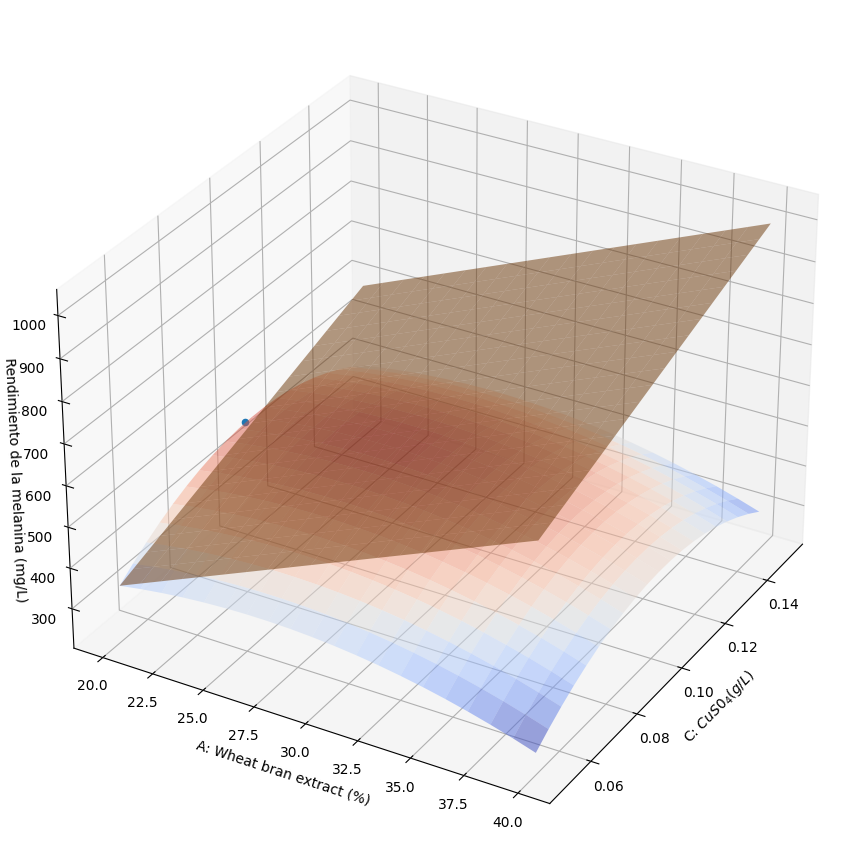

In [169]:
fig = plt.figure(figsize=(11, 11))

ax = fig.add_subplot(projection='3d')
ax.plot_surface(A, C , ecuacion(A, B, C), cmap='coolwarm',linewidth=0.5, antialiased=True, alpha=0.5)
ax.plot_surface(A, C, ecuacion_plano(puntos), linewidth=0.5, antialiased=True, alpha = 0.5) #Plano del presupuesto
ax.scatter(model.A(),model.C(),resp1(model.A(),model.B(),model.C()), alpha = 1) #Presupuesto adecuado evaluado en la función


# Etiquetar los ejes
ax.set_xlabel('A: Wheat bran extract (%)')
ax.set_ylabel('C: $CuS0_4(g/L)$')
ax.set_zlabel('Rendimiento de la melanina (mg/L)', labelpad=-0.3)

ax.zaxis._axinfo['juggled'] = (1,2,1)

# Mostrar la gráfica
plt.show()

#### Gráfica B-C-Y

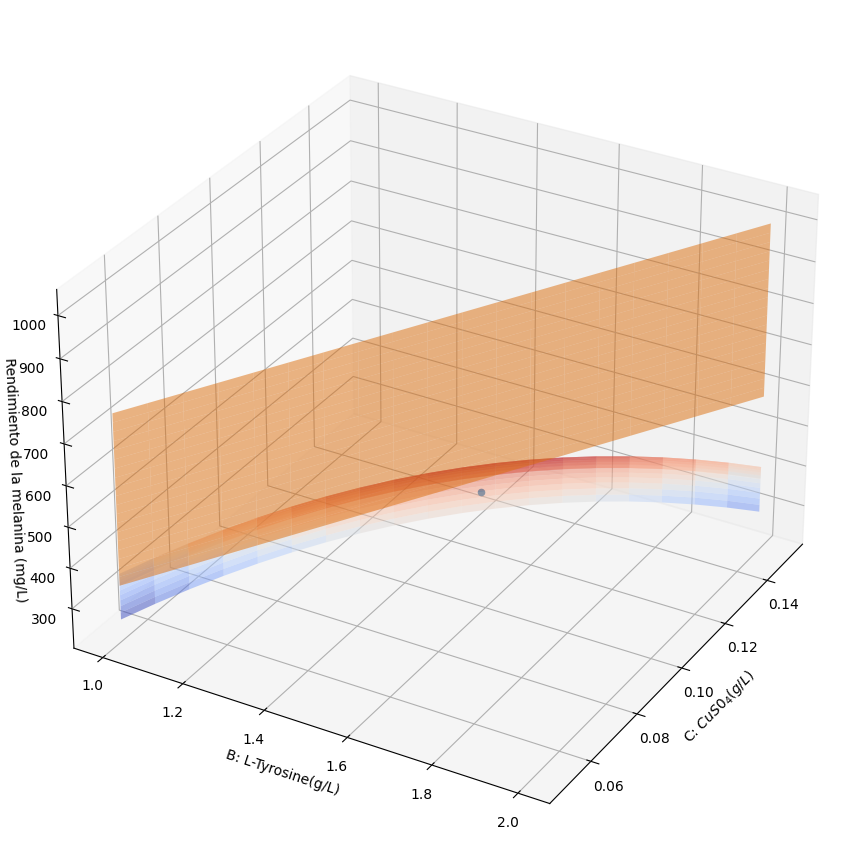

In [170]:
fig = plt.figure(figsize=(11, 11))

ax = fig.add_subplot(projection='3d')
ax.plot_surface(B, C , ecuacion(A, B, C), cmap='coolwarm',linewidth=0.5, antialiased=True, alpha=0.5)
ax.plot_surface(B, C, ecuacion_plano(puntos), linewidth=0.5, antialiased=True, alpha = 0.5) #Plano del presupuesto
ax.scatter(model.B(),model.C(),resp1(model.A(),model.B(),model.C()), alpha = 1) #Presupuesto adecuado evaluado en la función

# Etiquetar los ejes
ax.set_xlabel('B: L-Tyrosine(g/L)')
ax.set_ylabel('C: $CuS0_4(g/L)$')
ax.set_zlabel('Rendimiento de la melanina (mg/L)', labelpad=-0.3)

ax.zaxis._axinfo['juggled'] = (1,2,1)

# Mostrar la gráfica
plt.show()